In [1]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [2]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,1,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"","
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,1,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"","
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {..."
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,0,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r..."


In [3]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [4]:
# drop the unwanted columns
for i in data.iloc[:5, :][[ 'ownername', 'reponame', 'github_id']].values:
    print(i)

['stylelint' 'stylelint' 1895]
['binary-com' 'SmartCharts' 404]
['letsencrypt' 'boulder' 3434]
['PyCQA' 'astroid' 486]
['compsy' 'vsv' 379]


In [5]:
# remove accepted requests and remove data where gender is unknown
rejected_data = data.loc[data['merged_or_not'] == 0]
rejected_data = rejected_data.loc[rejected_data['contrib_gender'].notna()]

In [6]:
rejected_data.shape

(8561, 141)

In [7]:
# drop columns that we do not need
rejected_data = rejected_data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [8]:
# characteristics are from the paper (https://yuyue.github.io/res/paper/newPR_MSR2020.pdf)
# prepare characteristics to drop (contributor characteristics, project characteristics, are characteristics that the contributor cannot control)
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [9]:
# drop unwanted characteristics
rejected_data.drop(contributor_characteristics, axis=1, inplace=True)
rejected_data.drop(project_characteristics, axis=1, inplace=True)
rejected_data.drop(unable_to_control, axis=1, inplace=True)

In [10]:
rejected_data.shape

(8561, 78)

In [11]:
# label encode the contrib_gender column to 0 and 1
le = LabelEncoder()
le.fit(rejected_data['contrib_gender'])
rejected_data['contrib_gender'] = le.transform(rejected_data['contrib_gender'])

In [12]:
# encode all the columns that are not numerical, and save their label encoders
encoders = { 'contrib_gender' : le }
for column in rejected_data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(rejected_data[column])
    rejected_data[column] = le_col.transform(rejected_data[column])
    encoders[column] = le_col

In [13]:
rejected_data['contrib_gender']

9        1
16       1
49       1
53       0
55       1
        ..
75849    1
75854    1
75855    1
75883    1
75898    1
Name: contrib_gender, Length: 8561, dtype: int64

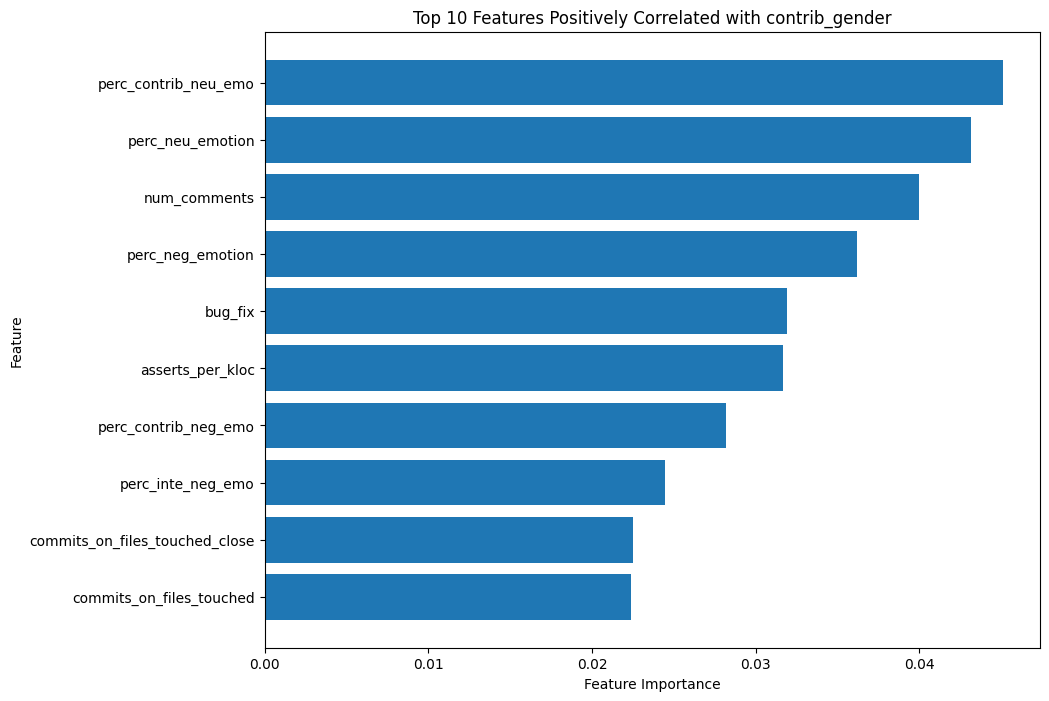

In [14]:
import matplotlib.pyplot as plt

# Calculate correlations using Spearman's rank correlation
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)
corr = correlation_data.corr(method='spearman')
correlation = corr['contrib_gender']

# Sort correlations by value, excluding 'contrib_gender' and negative correlations
sorted_correlations = sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: -x[1])

# Get the top 10 features
top_10_features = sorted_correlations[:10]

# Convert the features and their correlations to a DataFrame
df = pd.DataFrame(top_10_features, columns=['Feature', 'Correlation'])

# Sort the DataFrame by correlation
df = df.sort_values('Correlation', ascending=True)

# Plot the correlations
plt.figure(figsize=(10, 8))
plt.barh(df['Feature'], df['Correlation'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Positively Correlated with contrib_gender')
plt.show()

In [15]:
# find correlation to see which features are important
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)

# Use Spearman's rank correlation coefficient instead of Pearson's
corr = correlation_data.corr(method='spearman')

correlation = corr['contrib_gender']
sorted(correlation.items(), key=lambda x: -x[1])

[('contrib_gender', 1.0),
 ('pull_request_id', -0.0767021343332833),
 ('mergetime_minutes', nan),
 ('perc_contrib_neu_emo', 0.045096281096575014),
 ('perc_neu_emotion', 0.04317706794869777),
 ('num_comments', 0.03994948577637724),
 ('perc_neg_emotion', 0.0361993829371676),
 ('bug_fix', 0.0319254552763849),
 ('asserts_per_kloc', 0.03166925955684892),
 ('perc_contrib_neg_emo', 0.028166510517095577),
 ('perc_inte_neg_emo', 0.02447773980748406),
 ('commits_on_files_touched_close', 0.022525581136815312),
 ('commits_on_files_touched', 0.02236156211317068),
 ('test_cases_per_kloc', 0.022353620240929),
 ('test_lines_per_kloc', 0.021909759080292374),
 ('watchers', 0.021173757042176902),
 ('ci_latency', 0.02016065071126624),
 ('files_modified_open', 0.019769681303247688),
 ('ci_test_passed', 0.018965514944050826),
 ('code_churn_open', 0.018850013580914513),
 ('churn_deletion', 0.018352348966557547),
 ('churn_deletion_open', 0.01772372795059077),
 ('churn_addition_open', 0.016610422412943665),
 (

In [16]:
# chose features that have correlation greater than 0.02
threshold = 0.02 # moderate relationship or higher
high_correlation = list(filter(lambda x : x[1] >= threshold, sorted(correlation.items(), key=lambda x: -x[1])))
high_correlation_feat = list(map(lambda x : x[0], high_correlation))
high_correlation_feat.remove('contrib_gender')

In [17]:
# get data and clean up data by removing n/a values
features = high_correlation_feat
print(features)
# features = ['account_creation_days',  'contrib_open',  'part_num_issue',  'perc_neu_emotion',  'num_participants',  'perc_pos_emotion',  'ci_test_passed',  'asserts_per_kloc',  'followers',  'num_issue_comments',  'perc_neg_emotion',  'lifetime_minutes',  'test_inclusion',  'ci_exists',  'acc_commit_num',  'core_member',  'num_comments',  'at_tag',  'pushed_delta',  'part_num_commit',  'first_response_time',  'ci_latency',  'project_age',  'ci_build_num',  'first_pr',  'hash_tag',  'test_churn',  'num_commit_comments',  'comment_conflict',  'prev_pullreqs',  'bug_fix',  'churn_deletion',  'has_comments',  'has_participants',  'reviewer_comment',  'contrib_comment',  'inte_comment',  'has_exchange',  'same_country',  'perc_contrib_neu_emo',  'social_strength',  'agree_diff',  'contrib_rate_author',  'inte_open',  'contrib_follow_integrator',  'extra_diff',  'num_comments_con',  'first_close_minutes',  'perc_inte_pos_emo',  'neur_diff',  'perc_contrib_neg_emo',  'perc_inte_neu_emo',  'cons_diff',  'same_affiliation',  'test_inclusion_open',  'perc_inte_neg_emo',  'num_code_comments_con',  'friday_effect',  'test_churn_open',  'other_comment',  'perc_contrib_pos_emo',  'integrator_availability',  'churn_deletion_open']
rejected_data_cleaned = rejected_data[[*features, 'contrib_gender']].dropna()
X = rejected_data_cleaned[features]
y = rejected_data_cleaned['contrib_gender']

['perc_contrib_neu_emo', 'perc_neu_emotion', 'num_comments', 'perc_neg_emotion', 'bug_fix', 'asserts_per_kloc', 'perc_contrib_neg_emo', 'perc_inte_neg_emo', 'commits_on_files_touched_close', 'commits_on_files_touched', 'test_cases_per_kloc', 'test_lines_per_kloc', 'watchers', 'ci_latency']


In [18]:
rejected_data_cleaned.shape

(5553, 15)

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# split into train test val split
train_ratio = 0.70
test_ratio = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train the XGBoost classifier model on the balanced training data
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)

0.8619447779111644

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Convert your DataFrame to numpy arrays
X_array = X.values
y_array = y.values

# Initialize your classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    
    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    # Make predictions on the test data
    predictions = clf.predict(X_test)
    
    # Print the classification report
    print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.02      0.04        52
           1       0.91      1.00      0.95       504

    accuracy                           0.90       556
   macro avg       0.62      0.51      0.49       556
weighted avg       0.85      0.90      0.86       556

              precision    recall  f1-score   support

           0       0.17      0.04      0.07        45
           1       0.92      0.98      0.95       511

    accuracy                           0.90       556
   macro avg       0.54      0.51      0.51       556
weighted avg       0.86      0.90      0.88       556

              precision    recall  f1-score   support

           0       0.40      0.08      0.13        51
           1       0.91      0.99      0.95       505

    accuracy                           0.90       556
   macro avg       0.66      0.53      0.54       556
weighted avg       0.87      0.90      0.87       556

              preci

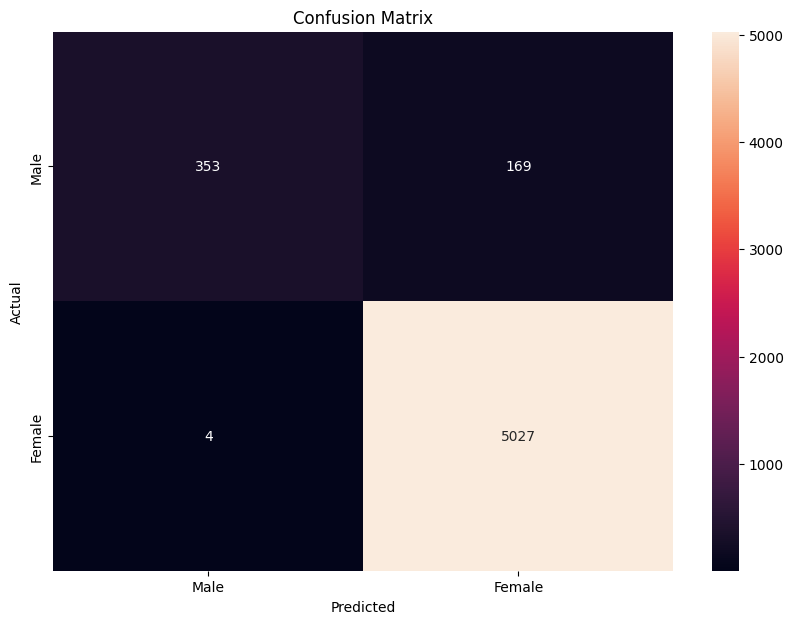

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model's predictions for the test set
y_pred = clf.predict(X)

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Replace the labels
labels = ['Male', 'Female']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)

plt.show()